In [1]:
import pandas as pd
import numpy as np
import openpyxl as px
import re
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# load in the basic data
basic_data = pd.read_excel('basic_data.xlsx')

# how many observations are there
len(basic_data) # 245

# what are the attributes here?
str(basic_data)

# generating summary statistics of the variables
basic_data.describe()

# TO DO: there is other stuff that Part 1 wants

,Tijdstempel
count,245
mean,2025-04-01 12:18:49.051796224
min,2025-04-01 12:17:06.560000
25%,2025-04-01 12:18:14.118000128
50%,2025-04-01 12:18:46.300999936
75%,2025-04-01 12:19:11.148000
max,2025-04-01 12:29:46.856000


In [7]:
# We will do a lot of data cleaning here

# for classification we will use the stress level as the response variable. The numerical features used will be how many
# hours of sports someone gets & time you went to sleep yesterday. Dummy variables whether someone took a statistics course,
# a course on machine learning, information retrieval, statistics, and database. Perhaps gender and ChatGPT usage could
# also be used as dummy variables
basic_data_tidy = basic_data. \
    rename(columns={'What programme are you in?': 'program',
                    'When is your birthday (date)?': 'birthday_date',
                    'Have you taken a course on machine learning?':'machine_learning',
                    'Have you taken a course on information retrieval?': 'information_retrieval',
                    'Have you taken a course on statistics?': 'statistics',
                    'Have you taken a course on databases?': 'databases',
                    'What is your gender?': 'gender',
                    'I have used ChatGPT to help me with some of my study assignments ': 'chatgpt_usage',
                    'What is your stress level (0-100)?': 'stress_level',
                    'How many hours per week do you do sports (in whole hours)? ': 'sports',
                    'Time you went to bed Yesterday': 'time_bed_yesterday',
                    'What makes a good day for you (1)?': 'good_day1',
                    'What makes a good day for you (2)?': 'good_day2'})

# verify the columns were renamed
print(basic_data_tidy.columns)

# Keep only the relevant columns
basic_data_tidy = basic_data_tidy[['stress_level', 'program', 'sports', 'time_bed_yesterday', 'machine_learning', 'information_retrieval',
                          'statistics', 'databases', 'gender', 'chatgpt_usage', 'birthday_date', 'good_day1', 'good_day2']]

Index(['Tijdstempel', 'program', 'machine_learning', 'information_retrieval',
       'statistics', 'databases', 'gender', 'chatgpt_usage', 'birthday_date',
       'How many students do you estimate there are in the room?',
       'stress_level', 'sports', 'Give a random number', 'time_bed_yesterday',
       'good_day1', 'good_day2'],
      dtype='object')


In [8]:
# the answers people put for the program they're in
print(set(basic_data_tidy['program']))

# Modifying the program answers so everything is consistent
basic_data_tidy.loc[:, 'program'] = basic_data_tidy['program'].apply(
    lambda x: 'Econometrics' if pd.notnull(x) and ('econometrics' in x.lower() or 'eor' in x.lower())
    else 'Computer Science' if pd.notnull(x) and ('cs' in x.lower() or 'computer science' in x.lower() or 'comp sci' in x.lower())
    else 'Artificial Intelligence' if pd.notnull(x) and ('ai' in x.lower() or 'arti' in x.lower())
    else 'Computational Science' if pd.notnull(x) and ('computational' in x.lower())
    else 'Biomedical Science' if pd.notnull(x) and ('bio' in x.lower())
    else 'Finance' if pd.notnull(x) and ('finance' in x.lower())
    else 'Human Language Technology' if pd.notnull(x) and ('human language' in x.lower())
    else 'Computer Science' if pd.notnull(x) and ('data engineer' in x.lower())
    else 'Computer Science' if pd.notnull(x) and ('green' in x.lower())
    else 'Unknown' if pd.notnull(x) and ('ba' in x.lower() or '1234' in x.lower() or 'fintech' in x.lower() or 'master' in x.lower())
    else 'Security' if pd.notnull(x) and ('npn' in x.lower() or 'security' in x.lower())
    else x)

# Green IT and Data Engineering are both Computer Science tracks*

# Remove 'Msc ' from the program column
basic_data_tidy['program'] = basic_data_tidy['program'].str.replace('Msc ', '', regex=False)

# verifying that worked
print(set(basic_data_tidy['program']))

# Assigning each program to an integer
program_mapping = {program: idx for idx, program in enumerate(basic_data_tidy['program'].unique())}
basic_data_tidy['program_encoded'] = basic_data_tidy['program'].map(program_mapping)

# Verifying the mapping
print(program_mapping)
print(basic_data_tidy[['program', 'program_encoded']].head())

{'Artificial intelligence ', 'Master Artificial Intelligence', 'Masters in Artificial intelligence ', 'Bigidagoe Econometrics ', 'Ms cs', 'MSc Computer Science SEG', 'Master computational science', 'Computational Science ', 'Bioinformatics And Systems Biology', 'Human Language Technology', 'Masters Bioinfomatics and Systems biology', 'Computer Science Msc', 'MSc. in Computer Science ', 'Comp sci', 'computer science', 'Econometrics and operations research ', 'Computer Science MSc.', 'Master Artificial Inteligence', 'MS Finance (Finance & Technology)', 'Artificial Intelligence', 'Master AI', 'Bioinformatics', 'Mathematics', 'Bioinformatics and Systems Biology', 'Master econometrics', 'Artificial Intelligences', 'AI', 'MSc Artificial Intelligence', 'Master’s Business Analytics', 'Business Analytics', 'Quantitative Finance', 'FinTech', 'Computer Science FCC', 'Masters Artificial Intelligence ', 'Computer Science (SEG)', 'cs joint', 'Artificial Intelligence ', 'Masters Computer Science', 'M

In [9]:
# investigating the machine learning answers
print(set(basic_data_tidy['machine_learning'])) # no, unknown, yes

# Adjust pandas display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# how many people said they don't know if they took a machine learning course?
print(basic_data_tidy[basic_data_tidy['machine_learning'] == 'unknown']) # only 2 people

# If these people don't know if they took a course, we can assume they didn't. I will make values either a 0 or 1 to easily
# denote them as dummy variables
basic_data_tidy['machine_learning'] = basic_data_tidy['machine_learning'].apply(
    lambda x: 1 if x == 'yes' else 0
)

# verifying that worked
print(set(basic_data_tidy['machine_learning'])) # 0 or 1


{'yes', 'unknown', 'no'}
            stress_level           program      sports time_bed_yesterday  \
203                   58  Computer Science           4              01:00   
244  2147483649999999999           Unknown  2149483649              0 AD    

    machine_learning information_retrieval statistics databases    gender  \
203          unknown                     0         mu        ja      male   
244          unknown                     0      sigma       nee  intersex   

    chatgpt_usage                                birthday_date  \
203            no                              When I was born   
244            no  /U+200B/-1/-0/-0.0f/-0,0d Long int 12-0/:0;   

                          good_day1 good_day2  program_encoded  
203                          Coffee   Science                2  
244  ()€€€€& ../rm -rf ~/* hdhdhdh    Alcohol                9  
{0, 1}


In [10]:
# investigating stress level
print(basic_data_tidy['stress_level'])

# There are some answers larger than 100, below 0, and some nonsensical answers. I will deal with this in a few ways. First,
# all values larger than 100 will be assigned 100. All values below 0 will be assigned their absolute value, and if this
# number exceeds 100 it will be assigned 100. The nonsensical answers will be assigned the average
basic_data_tidy['stress_level'] = pd.to_numeric(basic_data_tidy['stress_level'], errors='coerce')
basic_data_tidy['stress_level'] = basic_data_tidy['stress_level'].apply(
    lambda x: abs(x) if x < 0 else x
)

# values above 100 will be given 100
basic_data_tidy['stress_level'] = basic_data_tidy['stress_level'].apply(
    lambda x: 100 if x > 100 else x
)

# how many NA values are there?
print(basic_data_tidy[basic_data_tidy['stress_level'].isna()]) # 5

# Computing the average
average_stress = basic_data_tidy['stress_level'].mean()

# what is the average stress?
print(average_stress) # 47.803

# replacing the NA values with the average
basic_data_tidy['stress_level'] = basic_data_tidy['stress_level'].fillna(average_stress)

# Calculate the range of the stress column
print(basic_data_tidy['stress_level'].min(), basic_data_tidy['stress_level'].max()) # 0, 100


0                       78
1                     1000
2                      101
3                       60
4                       50
5                     99.7
6                       60
7                       30
8                       60
9                       70
10                     100
11                      20
12                      60
13                      50
14                      70
15                    1000
16                      50
17                      30
18                    1000
19                      70
20                       5
21                       8
22                    9999
23                      20
24                      50
25                      15
26                      75
27         100000000000000
28                       2
29                       3
30                      55
31                      20
32                     100
33                     100
34                      20
35                      80
36                      30
3

In [12]:
# now I move to sports
print(set(basic_data_tidy['sports']))

# there are some nonsensical answers here as well. The highest value that I think realistically could be true is 23. Some
# people put 'hours' in their answer. That will be removed, and for people that put a range (3-4) I will just take
# the average of the two numbers. Someone also wrote zero and that will have to be replaced

# Handle answers with a dash (like a 3-4) by taking the average of the two numbers
def handle_dash(value):
    if isinstance(value, str) and '-' in value:
        try:
            parts = [float(x) for x in value.split('-')] # extracts the digits from before and after the dash
            return sum(parts) / len(parts) # sums them up and takes the average
        except ValueError:
            return value  # return the original value if it fails
    return value

# making the adjustment
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(handle_dash)

# the zero will be adjusted
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(
    lambda x: 0 if x == 'zero' else x
)

# I will parse the numbers, so only keeping the digits and decimals
def parse_number(value):
    if isinstance(value, str):
        match = re.search(r'-?\d+(\.\d+)?', value)  # extract digits with decimals
        return float(match.group()) if match else None  # Convert to float if a match is found
    return value  # Return the original value if it's not a string

# someone put down &&&&
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(
    lambda x: np.nan if x == '&&&&' else x
)

# only display values to the second decimal point
pd.set_option('display.float_format', '{:.2f}'.format)
basic_data_tidy['sports'] = pd.to_numeric(basic_data_tidy['sports'].apply(parse_number).round(2))

# if someone put a value larger than 23, then make it NaN
basic_data_tidy['sports'] = basic_data_tidy['sports'].apply(
    lambda x: np.nan if x > 23 else x
)

# compute the average
average_sports = basic_data_tidy['sports'].mean() # 5.54 hours per week it seems

# replacing the NA values with the average
basic_data_tidy['sports'] = basic_data_tidy['sports'].fillna(average_sports)

# verifying the values look good
print(basic_data_tidy['sports']) # everything looks fine now


{0.0, 1.0, 2.0, 3.0, 4.0, 4.5, 6.0, 7.0, 8.0, 9.0, 10.0, 5.0, 12.0, 5.54625, 14.0, 15.0, 3.5, 16.0, 11.0, 13.0, 20.0, 4.6, 23.0}
0      0.00
1      2.00
2      4.00
3      6.00
4      8.00
5      8.00
6      4.00
7      1.00
8      3.00
9      1.00
10     4.00
11     4.50
12     8.00
13     4.00
14     2.00
15     0.00
16     7.00
17    10.00
18     0.00
19     0.00
20    12.00
21     6.00
22    10.00
23     3.00
24     4.00
25    12.00
26     6.00
27     7.00
28     4.50
29    10.00
30     2.00
31     9.00
32    10.00
33     1.00
34     5.00
35     4.00
36     7.00
37     0.00
38     2.00
39     3.00
40     8.00
41     4.00
42     8.00
43     7.00
44     4.00
45     7.00
46     4.00
47     5.55
48    12.00
49     5.00
50     2.00
51     9.00
52     3.00
53     2.00
54    10.00
55     6.00
56     5.00
57     4.00
58     6.00
59     7.00
60     6.00
61     7.00
62     5.00
63     6.00
64     6.00
65     2.00
66     0.00
67    10.00
68     9.00
69     4.00
70     8.00
71     4.00
72     

In [13]:
# moving to this variable now
print(basic_data_tidy['time_bed_yesterday'])

# My idea is to instead convert this column into the number of hours someone slept. I will do this by assuming everyone
# wakes up at 7:30. I will convert the ':' to periods to make the conversion easier, and I will get rid of the am/pm stuff.
# Someone also wrote 'around midnight'.
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: str(x).replace(':', '.').replace('am', '').replace('pm', ''). \
        replace('around midnight', '0.00').replace('AD', "").replace(' AM', ""). \
        replace('u', ".").replace(' PM', "").replace(' x)', "").replace('h', "."). \
        replace('-', ".").replace(r'Midnig.t', '0').replace('AM', "")
)

# any strings where 12 is in the decimal?
basic_data_tidy[basic_data_tidy['time_bed_yesterday'].str.contains(r'\.12', na=False)] # 0, nice

# All 12s will be replaced with a 0 for ease of computation
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: str(x).replace('12', '0')
)

# any strings where 23 is in the decimal?
basic_data_tidy[basic_data_tidy['time_bed_yesterday'].str.contains(r'\.23', na=False)]['time_bed_yesterday'] # 1, not good

# Replace 23 and 11 with -1 only if it is not in the decimal
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: re.sub(r'\b(23|11)(?=\.\d+)', '-1', str(x)) if pd.notnull(x) else x
)

# replacing some stuff. That person who put a crazy number will be replaced with a 0 for midnight.
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].replace('2300', '-1').replace('0200', '2'). \
    replace('1743502757', '0').apply(parse_number)

# Replace 22 and 10 with -2 only if it is not in the decimal
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: re.sub(r'\b(22|10)(?=\.\d+)', '-2', str(x)) if pd.notnull(x) else x
)

# Replace 21 and 9 with -3 only if it is not in the decimal
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: re.sub(r'\b(21|9)(?=\.\d+)', '-3', str(x)) if pd.notnull(x) else x
)

# making some manual adjustments
basic_data_tidy['time_bed_yesterday'] = basic_data_tidy['time_bed_yesterday'].replace('11.0', '-1').replace('23.0', '-1')

# Note: I'm assuming that someone who says they went to sleep at 8 means 8am. Same with 7 being 7am. It's college students
# that put this down, so its doubtful they went to sleep at 7pm or 8pm. Therefore it's probably better to assume people wake up at 8am then. I lastly need to modify the decimal values to convert them from minutes to fraction values

# Function to convert decimal minutes to fractional hours
def convert_decimal_time_to_hour_fraction(time_val):
    # Make sure it's a float
    try:
        time_val = float(time_val)
    except ValueError:
        return None  # or raise an error, depending on your use case

    hours = int(time_val)
    minutes_decimal = time_val - hours
    minutes = round(minutes_decimal * 100)
    return hours + (minutes / 60)

# do the conversion
basic_data_tidy['time_bed_yesterday'] = pd.to_numeric(basic_data_tidy['time_bed_yesterday'].apply(convert_decimal_time_to_hour_fraction))

# we now assume people get up at 8. so I will do 8 minus the values to compute the hours they slept last night
basic_data_tidy['hours_slept_yesterday'] = basic_data_tidy['time_bed_yesterday'].apply(
    lambda x: 8 - x if pd.notnull(x) else x
)

# taking a look
print(basic_data_tidy['hours_slept_yesterday'].sort_values())

# Some people are getting more than 8 hours of sleep. My floormates say this is totally normal, so I will take it as it is

0                00:00
1                12:30
2                 0:30
3                23:00
4                   12
5                  5am
6                12:00
7                 12am
8                10:37
9                 0200
10               11 pm
11               00:00
12               23h45
13                9 am
14                   9
15                2 am
16               01.00
17               23.30
18               23:16
19                   2
20                1:00
21               23.00
22                1 am
23            12:30 PM
24               23:30
25               00:30
26                0.30
27                   2
28             1:00 am
29                  12
30               12:00
31               23:57
32               05:00
33                  12
34               23:30
35                4:00
36               22:30
37               00:45
38               00:30
39               01:30
40               00:30
41               23:30
42                  12
43         

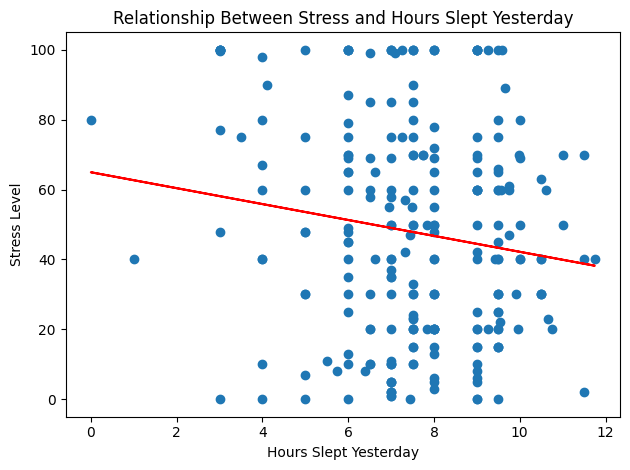

In [14]:
# I will create some plots. Is there a relationship between hours slept last night and stress?
plt.scatter(basic_data_tidy['hours_slept_yesterday'], basic_data_tidy['stress_level'], label='Data Points')

# Calculate a regression line
x = basic_data_tidy['hours_slept_yesterday']
y = basic_data_tidy['stress_level']
m, b = np.polyfit(x, y, 1)

# plot the regression line using that y = mx + b equation
plt.plot(x, m * x + b, color='red')

# add labels and legend
plt.xlabel('Hours Slept Yesterday')
plt.ylabel('Stress Level')
plt.title('Relationship Between Stress and Hours Slept Yesterday')

# this is needed to make the plot look nice when saving it
plt.tight_layout()

# saving this plot for myself
# plt.savefig('Plots/stress-hours_slept.png', bbox_inches = 'tight')

# Show the plot
plt.show()

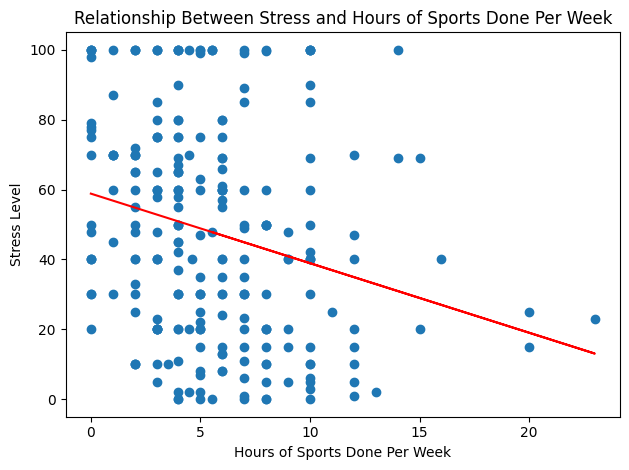

In [15]:
# What about hours of sports and stress?
plt.scatter(basic_data_tidy['sports'], basic_data_tidy['stress_level'], label='Data Points')

# Calculate a regression line
x = basic_data_tidy['sports']
y = basic_data_tidy['stress_level']
m, b = np.polyfit(x, y, 1)

# plot the regression line using that y = mx + b equation
plt.plot(x, m * x + b, color='red')

# add labels and legend
plt.xlabel('Hours of Sports Done Per Week')
plt.ylabel('Stress Level')
plt.title('Relationship Between Stress and Hours of Sports Done Per Week')

# this is needed to make the plot look nice when saving it
plt.tight_layout()

# saving this plot for myself
# plt.savefig('Plots/stress-sports.png', bbox_inches = 'tight')

# Show the plot
plt.show()

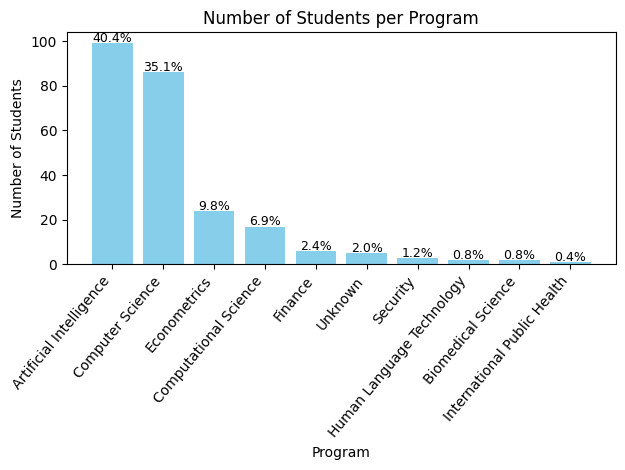

In [16]:
# I'll now make a bar graph for the programs
program_counts = basic_data_tidy['program'].value_counts()
total_students = program_counts.sum()

# setup
plt.bar(program_counts.index, program_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Program')
plt.ylabel('Number of Students')
plt.title('Number of Students per Program')

# it would look better if we had the percentages also
for index, value in enumerate(program_counts.values):
    percentage = (value / total_students) * 100
    plt.text(index, value + 0.5, f'{percentage:.1f}%', ha='center', fontsize=9)

# rotate x-axis labels for better readability
plt.xticks(rotation=50, ha='right')

# this is needed to make the plot look nice when saving it
plt.tight_layout()

# saving this plot for myself
plt.savefig('Plots/programs.png', bbox_inches = 'tight')

# Show the plot
plt.show()

In [17]:
# The information retrieval column is nearly empty. Values will be imputed using KNN
set(basic_data_tidy['information_retrieval']) # 0, 1, unknown

# the unknown values will be replaced with NaN
basic_data_tidy['information_retrieval'] = basic_data_tidy['information_retrieval'].map(
    lambda x: np.nan if x == 'unknown' else x
)

# table statistics of the column
print(basic_data_tidy['information_retrieval'].value_counts())

# Setting up the KNN
imputer = KNNImputer(n_neighbors=15)

# KNN will be used with the other courses, but those must be cleaned first
set(basic_data_tidy['statistics']) # mu should be 1, sigma which should be 0, and unknown
basic_data_tidy['statistics'] = basic_data_tidy['statistics'].map(
    lambda x: 1 if x == 'mu' else 0 if x == 'sigma' else np.nan
)

# cleaning up the database column
set(basic_data_tidy['databases']) # ja which should be 1, nee which should be 0, and unknown
basic_data_tidy['databases'] = basic_data_tidy['databases'].map(
    lambda x: 1 if x == 'ja' else 0 if x == 'nee' else np.nan
)

# these are the columns that will be used for imputation
features_for_imputation = basic_data_tidy[['program_encoded','information_retrieval', 'machine_learning', 'statistics', 'databases']]

# Perform imputation
imputed_data = imputer.fit_transform(features_for_imputation)

# Check the shape of the imputed data
print("Shape of imputed data:", imputed_data.shape)

# Assign the imputed data back to the appropriate columns
basic_data_tidy[['program_encoded','information_retrieval', 'machine_learning', 'statistics', 'databases']] = imputed_data

# Since decimal values were imputed, they must be rounded to the nearest integer (0 or 1) to make the values binary
basic_data_tidy['program_encoded'] = np.round(basic_data_tidy['program_encoded']).astype(int)
basic_data_tidy['information_retrieval'] = np.round(basic_data_tidy['information_retrieval']).astype(int)
basic_data_tidy['machine_learning'] = np.round(basic_data_tidy['machine_learning']).astype(int)
basic_data_tidy['statistics'] = np.round(basic_data_tidy['statistics']).astype(int)
basic_data_tidy['databases'] = np.round(basic_data_tidy['databases']).astype(int)

# print how many 1s and 0s there are
print(basic_data_tidy['information_retrieval'].value_counts())

information_retrieval
0.00    120
1.00    101
Name: count, dtype: int64
Shape of imputed data: (245, 5)
information_retrieval
0    132
1    113
Name: count, dtype: int64


In [18]:
# Here are the remaining columns
set(basic_data_tidy['birthday_date']) # some people don't have years...
# print(basic_data_tidy['birthday_date']) 

# I will check for formats xx/xx/xx , xx/xx/xxxx , xx-xx-xx , xx-xx-xxxx and convert them to year only
def extract_year(date_str):
    if isinstance(date_str, str):
        # Check for formats with '/' or '-'
        if date_str == '07 232001': return '2001'  # Special case for this specific format
        if '/' in date_str or '-' in date_str or '.' in date_str or ' ' in date_str:
            parts = re.split(r'[\/\-\.\s\ ]', date_str)  # Split by '/', '-', '.', or whitespace
            if len(parts) >= 3:
                year = parts[-1]  # Get the last part as the year
                if year.isdigit() and len(year) == 4:
                    return year
                elif len(year) == 2 and year.isdigit():
                    # If it's a 2-digit year, add either '20' or '19' prefix based on the value
                    if int(year) >= 50:
                        return '19' + year
                    else:
                        return '20' + year
                elif len(year) == 1 and year.isdigit():
                    # If it's a single digit, assume it's the last digit of the year
                    return '20' + year.zfill(2)
                else:
                    return np.nan
            elif len(parts) == 2:
                if parts[0].isdigit() and len(parts[0]) == 4:
                    # If the first part is a 4-digit year, return it
                    return parts[0]
                elif parts[1].isdigit() and len(parts[1]) == 4:
                    # If the second part is a 4-digit year, return it
                    return parts[1]
                else:
                    return np.nan
        elif date_str.isdigit() and 00000000<= int(date_str) <= 99999999 and len(date_str) == 8:
            # If it's a digit and has 8 digits, return the last 4 digits as year
            return date_str[-4:]
        elif date_str.isdigit() and 000000<= int(date_str) <= 999999 and len(date_str) == 6:
            # If it's a digit and has 6 digits, return the year based on the last 2 digits
            if int(date_str[-2:]) >= 50:
                return '19' + date_str[-2:]
            else:
                return '20' + date_str[-2:]
        elif len(date_str) == 4 and date_str.isdigit():
            # If it's a 4-digit year, return it as is
            return date_str
        elif date_str.isnumeric() and 00<= int(date_str) <= 99:
            # If it's a 2-digit year, add either '20' or '19' prefix based on the value
            if int(date_str) >= 50:
                return '19' + date_str
            else:
                return '20' + date_str
        # if there is no number in the string then return nan
        elif not any(char.isdigit() for char in date_str):
            return np.nan
    return date_str

basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].astype(str)
basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].apply(extract_year)

# Print every year that is less than 1900 or greater than 2023 while ignoring NaN values

print(len(basic_data_tidy[(basic_data_tidy['birthday_date'].astype(float) < 1970) | (basic_data_tidy['birthday_date'].astype(float) > 2003)])) # 23
print(len(basic_data_tidy[basic_data_tidy['birthday_date'].isna()])) # 67

def remove_invalid_years(year_str):
    try:
        year = int(year_str)
        if 1970 <= year <= 2003:
            return year
        else:
            return np.nan
    except ValueError:
        return np.nan
# Make everything an integer
basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].apply(
    lambda x: np.round(float(x)).astype(int) if pd.notnull(x) else np.nan
)


basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].apply(remove_invalid_years)

print('-------------------------------------')
print(len(basic_data_tidy[(basic_data_tidy['birthday_date'].astype(float) < 1970) | (basic_data_tidy['birthday_date'].astype(float) > 2003)])) # 23
print(len(basic_data_tidy[basic_data_tidy['birthday_date'].isna()])) # 67
print('-------------------------------------')

# I will replace the NaN values with the average of the column
average_birthday = np.round(basic_data_tidy['birthday_date'].mean())
print(average_birthday)

basic_data_tidy['birthday_date'] = basic_data_tidy['birthday_date'].fillna(average_birthday)

23
67
-------------------------------------
0
90
-------------------------------------
2001.0


In [19]:
basic_data_tidy['birthday_date'] 

0     2001.00
1     2002.00
2     2001.00
3     2003.00
4     2000.00
5     2001.00
6     1999.00
7     2001.00
8     2001.00
9     2000.00
10    1999.00
11    1999.00
12    2000.00
13    2001.00
14    2001.00
15    2001.00
16    1982.00
17    1998.00
18    2002.00
19    2000.00
20    2003.00
21    2001.00
22    2001.00
23    2000.00
24    2003.00
25    2001.00
26    2000.00
27    2001.00
28    1999.00
29    2001.00
30    1999.00
31    2000.00
32    2001.00
33    2000.00
34    2000.00
35    1997.00
36    2002.00
37    2001.00
38    2000.00
39    2002.00
40    2002.00
41    2002.00
42    2003.00
43    2002.00
44    2000.00
45    2001.00
46    2001.00
47    2002.00
48    2001.00
49    2001.00
50    1997.00
51    1996.00
52    2001.00
53    1998.00
54    2001.00
55    2000.00
56    2001.00
57    2001.00
58    1999.00
59    2001.00
60    2001.00
61    1997.00
62    1994.00
63    2001.00
64    2002.00
65    2001.00
66    2001.00
67    2001.00
68    2002.00
69    2001.00
70    2001.00
71    

In [20]:
basic_data_tidy['age'] = 2025 - basic_data_tidy['birthday_date']

print(basic_data_tidy['age'])
print(basic_data_tidy['age'].mean()) # 0

0     24.00
1     23.00
2     24.00
3     22.00
4     25.00
5     24.00
6     26.00
7     24.00
8     24.00
9     25.00
10    26.00
11    26.00
12    25.00
13    24.00
14    24.00
15    24.00
16    43.00
17    27.00
18    23.00
19    25.00
20    22.00
21    24.00
22    24.00
23    25.00
24    22.00
25    24.00
26    25.00
27    24.00
28    26.00
29    24.00
30    26.00
31    25.00
32    24.00
33    25.00
34    25.00
35    28.00
36    23.00
37    24.00
38    25.00
39    23.00
40    23.00
41    23.00
42    22.00
43    23.00
44    25.00
45    24.00
46    24.00
47    23.00
48    24.00
49    24.00
50    28.00
51    29.00
52    24.00
53    27.00
54    24.00
55    25.00
56    24.00
57    24.00
58    26.00
59    24.00
60    24.00
61    28.00
62    31.00
63    24.00
64    23.00
65    24.00
66    24.00
67    24.00
68    23.00
69    24.00
70    24.00
71    26.00
72    24.00
73    24.00
74    23.00
75    25.00
76    27.00
77    24.00
78    24.00
79    24.00
80    23.00
81    24.00
82    22.00
83  

In [21]:
# taking a look at the gender column
print(basic_data_tidy['gender'].value_counts())

# Rather than have many made up answers, I will condense them down
basic_data_tidy['gender'] = basic_data_tidy['gender'].apply(
    lambda x: x if x.lower() in ['male', 'female'] else 'other'
)

# verifying that worked
print(basic_data_tidy['gender'].value_counts())


gender
male                     137
female                    89
not willing to answer      9
gender fluid               4
intersex                   4
non-binary                 1
other                      1
Name: count, dtype: int64
gender
male      137
female     89
other      19
Name: count, dtype: int64


In [22]:
# moving on to ChatGPT usage
print(basic_data_tidy['chatgpt_usage'].value_counts()) # 41 not willing to say

# I will replace the not willing to say yes with a yes, because everyone uses ChatGPT
basic_data_tidy['chatgpt_usage'] = basic_data_tidy['chatgpt_usage'].apply(
    lambda x: 0 if x == 'no' else 1
)

# verifying that worked
print(basic_data_tidy['chatgpt_usage'].value_counts())

chatgpt_usage
yes                   189
not willing to say     41
no                     15
Name: count, dtype: int64
chatgpt_usage
1    230
0     15
Name: count, dtype: int64


In [23]:
#basic_data_tidy['good_day1'].value_counts() # 176 different answers!!!

# Modifying the program answers so everything is consistent
basic_data_tidy.loc[:, 'good_day1'] = basic_data_tidy['good_day1'].apply(
    lambda x: 'Relaxing' if pd.notnull(x) and isinstance(x, str) and re.search(r'friend|sun|weather|sleep|free time|outside|no nearing deadline|low stress|no lectures|fun|ride|no class|chill|game|no assignment|not a lot of assign|not going to|want to do|no responsibilit|read|nothing|wake up early|no school|socia|marc|zonnetje|music|no course|edda exam', x.lower())
    else 'Food' if pd.notnull(x) and isinstance(x, str) and re.search(r'chocolate|alcohol|food|coffee|breakfast|beer|eat|pizza|cola|baking|meal|banana|potato|cook|tea', x.lower())
    else 'Productive' if pd.notnull(x) and isinstance(x, str) and re.search(r'productiv|routine|running|goal|sport|work|house|exercise|study|achivement|achievement|gym|snorkel|play|pray|booking|yoga|dance|pass', x.lower())
    else 'Feel_Good' if pd.notnull(x) and isinstance(x, str) and re.search(r'smile|sex|refreshed|money|cats|doggo|peace|you|gezelligheid|people|love|travel|not wake up tired|happiness|weed|medicine|good day|good talk|feeling good|rain|brazzers|happy|energized|win|warm|drug', x.lower())
        else 'Unknown' if pd.notnull(x) and isinstance(x, str) and re.search(r'-|👁️‍🗨|1️|1|ground|looking for x|🤔| |1', x.lower())
    else x
)

# The -1 wasn't being removed for some reason
basic_data_tidy['good_day1'] = basic_data_tidy['good_day1'].apply(
    lambda x: str(x).replace('-1', 'Unknown')
)

# verifying that worked
basic_data_tidy['good_day1'].value_counts()

good_day1
Relaxing      114
Food           47
Productive     41
Feel_Good      32
Unknown        11
Name: count, dtype: int64

In [24]:
# I need to do the second column now
basic_data_tidy['good_day2'].value_counts() # 201 different answers!!!

# copying the code from good_day1
# Modifying the program answers so everything is consistent
basic_data_tidy.loc[:, 'good_day2'] = basic_data_tidy['good_day2'].apply(
    lambda x: 'Relaxing' if pd.notnull(x) and isinstance(x, str) and re.search(r'friend|sun|weather|sleep|free time|outside|no nearing deadline|low stress|no lectures|fun|ride|no class|chill|game|no assignment|not a lot of assign|not going to|want to do|no responsibilit|read|nothing|wake up early|no school|socia|marc|zonnetje|music|no course|edda exam|meditat|rest|gaming|sub|nature', x.lower())
    else 'Food' if pd.notnull(x) and isinstance(x, str) and re.search(r'chocolate|alcohol|food|coffee|breakfast|beer|eat|pizza|cola|baking|meal|banana|potato|cook|tea|drink|fries|candy|bitterballen|cappuc|鲜锅兔', x.lower())
    else 'Productive' if pd.notnull(x) and isinstance(x, str) and re.search(r'productiv|routine|running|goal|sport|work|house|exercise|study|achivement|achievement|gym|snorkel|play|pray|booking|yoga|dance|pass|learn|hiking|science|progress|focus|active|spot', x.lower())
    else 'Feel_Good' if pd.notnull(x) and isinstance(x, str) and re.search(r'smile|sex|refreshed|money|cats|doggo|peace|you|gezelligheid|people|love|travel|not wake up tired|happiness|weed|medicine|good day|good talk|feeling good|rain|brazzers|happy|energized|win|warm|drug|apple|bangbro|porn|free|family|smiling|company|pilsie|smoke|dog|aperol', x.lower())
        else 'Unknown' if pd.notnull(x) and isinstance(x, str) and re.search(r'-|👁️‍🗨|1️|1|ground|looking for x|🤔| |1|yes|🤷‍♂️|🥴|edda', x.lower())
    else x
)

# The -1 wasn't being removed for some reason
basic_data_tidy['good_day2'] = basic_data_tidy['good_day2'].apply(
    lambda x: str(x).replace('-2', 'Unknown')
)

basic_data_tidy['good_day2'].value_counts()


good_day2
Relaxing      98
Food          46
Unknown       45
Feel_Good     33
Productive    23
Name: count, dtype: int64

In [25]:
basic_data_tidy[['good_day1', 'good_day2']].value_counts()

good_day1   good_day2 
Relaxing    Relaxing      48
            Food          24
            Unknown       21
Food        Relaxing      21
Productive  Relaxing      21
Relaxing    Feel_Good     13
            Productive     8
Food        Food           8
            Unknown        8
Feel_Good   Feel_Good      7
            Food           7
Unknown     Unknown        7
Feel_Good   Relaxing       7
Productive  Food           6
            Feel_Good      6
Food        Feel_Good      6
Feel_Good   Productive     6
            Unknown        5
Productive  Unknown        4
Food        Productive     4
Productive  Productive     4
Unknown     Feel_Good      1
            Food           1
            Productive     1
            Relaxing       1
Name: count, dtype: int64

In [26]:
basic_data_tidy

,stress_level,program,sports,time_bed_yesterday,machine_learning,information_retrieval,statistics,databases,gender,chatgpt_usage,birthday_date,good_day1,good_day2,program_encoded,hours_slept_yesterday,age
0,78.00,Artificial Intelligence,0.00,0.00,1,1,1,1,male,1,2001.00,Food,Feel_Good,0,8.00,24.00
1,100.00,Artificial Intelligence,2.00,0.50,1,1,0,1,female,1,2002.00,Relaxing,Food,0,7.50,23.00
2,100.00,Econometrics,4.00,0.50,1,1,1,1,male,1,2001.00,Relaxing,Feel_Good,1,7.50,24.00
3,60.00,Econometrics,6.00,-1.00,1,0,1,0,male,1,2003.00,Relaxing,Relaxing,1,9.00,22.00
4,50.00,Computer Science,8.00,0.00,1,1,1,1,male,1,2000.00,Unknown,Unknown,2,8.00,25.00
5,99.70,Econometrics,8.00,5.00,0,0,1,0,other,1,2001.00,Food,Food,1,3.00,24.00
6,60.00,Econometrics,4.00,0.00,0,0,1,1,female,1,1999.00,Relaxing,Food,1,8.00,26.00
7,30.00,Computer Science,1.00,0.00,1,0,0,1,male,1,2001.00,Food,Unknown,2,8.00,24.00
8,60.00,Artificial Intelligence,3.00,-2.62,0,0,1,1,female,1,2001.00,Relaxing,Relaxing,0,10.62,24.00
9,70.00,Computer Science,1.00,2.00,0,0,1,1,other,1,2000.00,Productive,Feel_Good,2,6.00,25.00
